In [1]:
import pandas as pd
import geopandas as gpd

from shared_utils import rt_utils, catalog_utils

from calitp_data_analysis import get_fs, geography_utils
from segment_speed_utils import helpers, time_series_utils, gtfs_schedule_wrangling, corridor_analysis
from segment_speed_utils.project_vars import SCHED_GCS, SEGMENT_GCS, GTFS_DATA_DICT, analysis_date
import numpy as np

In [282]:
import importlib
importlib.reload(corridor_analysis)

<module 'segment_speed_utils.corridor_analysis' from '/home/jovyan/data-analyses/rt_segment_speeds/segment_speed_utils/corridor_analysis.py'>

# develop and test some basic tools for corridor analysis

In [3]:
catalog = catalog_utils.get_catalog('gtfs_analytics_data')

In [4]:
catalog.speedmap_segments

{'dir': '${gcs_paths.SEGMENT_GCS}', 'stage1': '${speeds_tables.vp_dwell}', 'proxy_stop_times': 'stop_time_expansion/speedmap_stop_times', 'stage2': 'nearest/nearest_vp_speedmap_proxy', 'stage3': 'speedmap/stop_arrivals_proxy', 'stage3b': 'speedmap/stop_arrivals', 'stage4': 'speedmap/speeds', 'trip_stop_cols': ['trip_instance_key', 'stop_sequence', 'stop_sequence1'], 'shape_stop_cols': ['shape_array_key', 'shape_id'], 'stop_pair_cols': ['stop_pair', 'stop_pair_name', 'segment_id'], 'route_dir_cols': ['route_id', 'direction_id'], 'segments_file': 'segment_options/speedmap_segments', 'shape_stop_single_segment': 'rollup_singleday/speeds_shape_speedmap_segments', 'shape_stop_single_segment_detail': 'rollup_singleday/speeds_shape_speedmap_segments_detail', 'route_dir_single_segment': 'rollup_singleday/speeds_route_dir_speedmap_segments', 'route_dir_multi_segment': 'rollup_multiday/speeds_route_dir_speedmap_segments', 'min_trip_minutes': '${speed_vars.time_min_cutoff}', 'max_trip_minutes': 1

In [5]:
analysis_date

'2024-12-11'

In [6]:
# path = f'{catalog.speedmap_segments.dir}{catalog.speedmap_segments.stage4}_{analysis_date}.parquet'

In [7]:
path = f'{catalog.speedmap_segments.dir}{catalog.speedmap_segments.shape_stop_single_segment_detail}_{analysis_date}.parquet'

In [8]:
path

'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/rollup_singleday/speeds_shape_speedmap_segments_detail_2024-12-11.parquet'

In [9]:
detail = gpd.read_parquet(path).round(2)

In [10]:
frequencies = detail[['route_id', 'schedule_gtfs_dataset_key', 'trips_hr_sch']].drop_duplicates()
frequencies = frequencies.groupby(['route_id', 'schedule_gtfs_dataset_key']).max().reset_index().sort_values('trips_hr_sch', ascending=False)

In [11]:
# frequencies = (detail[['shape_array_key', 'route_id', 'schedule_gtfs_dataset_key']].drop_duplicates(
#                     ).merge(frequencies, on=['route_id', 'schedule_gtfs_dataset_key'])
#               )

In [12]:
frequencies

,route_id,schedule_gtfs_dataset_key,trips_hr_sch
1511,807,2a0571758141f412b6a546fd70a65bf3,12.00
849,38R,7cc0cb1871dfd558f11a2885c145d144,10.67
1031,49,7cc0cb1871dfd558f11a2885c145d144,10.33
978,4444,cc53a0dbf5df90e3009b9cb5d89d80ba,10.00
495,22,7cc0cb1871dfd558f11a2885c145d144,10.00
...,...,...,...
1251,613,587e730fac4db21d54037e0f12b0dd5d,0.20
1299,635,364d59b3aea55aec2962a0b3244a40e0,0.20
1430,72,5456c80d420043e15c8eb7368a8a4d89,0.20
1327,654,015d67d5b75b5cf2b710bbadadfb75f5,0.20


In [13]:
detail.head(3)

,schedule_gtfs_dataset_key,shape_array_key,shape_id,route_id,direction_id,stop_pair,stop_pair_name,segment_id,time_of_day,p50_mph,...,p80_mph,name,caltrans_district,organization_source_record_id,organization_name,base64_url,geometry,n_trips_sch,trips_hr_sch,route_short_name
0,015d67d5b75b5cf2b710bbadadfb75f5,43f0d67e5131502a51f9330e04bacc55,20,228,0.0,40512__40514,Sir Francis Drake Blvd & Olema Rd__Sir Francis...,40512-40514-1,AM Peak,11.83,...,11.83,Bay Area 511 Marin Schedule,04 - Oakland,recNOb7pqBRlQVG5e,Marin County Transit District,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,"LINESTRING (-122.60413 38.00022, -122.60416 38...",3,1.0,228
1,015d67d5b75b5cf2b710bbadadfb75f5,43f0d67e5131502a51f9330e04bacc55,20,228,0.0,40514__40516,Sir Francis Drake Blvd & Alhambra Circle__Sir ...,40514-40516-1,AM Peak,15.52,...,19.79,Bay Area 511 Marin Schedule,04 - Oakland,recNOb7pqBRlQVG5e,Marin County Transit District,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,"LINESTRING (-122.60045 37.99908, -122.60037 37...",3,1.0,228
2,015d67d5b75b5cf2b710bbadadfb75f5,43f0d67e5131502a51f9330e04bacc55,20,228,0.0,40516__40518,Sir Francis Drake Blvd At Drake Manor Apts__Si...,40516-40518-1,AM Peak,15.69,...,20.79,Bay Area 511 Marin Schedule,04 - Oakland,recNOb7pqBRlQVG5e,Marin County Transit District,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,"LINESTRING (-122.59907 37.99704, -122.59894 37...",3,1.0,228


## need trip-level (pre-aggregation) gdf to properly calculate metrics

In [14]:
st4 = corridor_analysis.import_trip_speeds(analysis_date)

2.2 percent of segments have no speed


## corridor specification

In [15]:
# rt_utils.show_full_df(pd.read_parquet('../ca_transit_speed_maps/_rt_progress_2024-12-11.parquet').sort_values(['caltrans_district', 'organization_name']))

## define corridor

In [16]:
# shape_id = '4953'
# start_seg_id = '18088-18089-1'
# end_seg_id = '16800-16806-1'

sf = 'rechaapWbeffO33OX'
shape_id = '800'
start_seg_id = '14970-17900-2'
end_seg_id = '16357-16358-1'

# hum = 'recynxkqEoo9dJEvw'
# shape_id = 'p_1435936'
# start_seg_id = '1252-4209812-1'
# end_seg_id = '1276-1277-1'

In [17]:
gdf = corridor_analysis.corridor_from_segments(speed_segments_gdf=detail, organization_source_record_id=sf, shape_id=shape_id,
                      start_seg_id=start_seg_id, end_seg_id=end_seg_id)

## Corridor Measurements

Previous logic:

For each trip, get from the last stop before entering corridor to the first stop after exiting corridor. This was done on stop_sequence

Now,

* first sjoin with aggregated data (has geom). Sjoining on segments is equivalent to previous methodology, since it will yield the last stop before entry to the first stop after exiting...
* avoid doing scheduled delay metric for now...
* 

In [18]:
corridor_trips = corridor_analysis.find_corridor_data(detail, gdf, st4)
corridor_results = corridor_analysis.analyze_corridor_trips(corridor_trips)

0.8 percent of trips with zero seconds
0.8 percent of trips with speeds > 80mph


In [19]:
# m = gdf.explore(color='gray')

# corridor_trips[['route_short_name', 'shape_length', 'geometry']].explore(m=m, column='shape_length')

In [20]:
# corridor_results.head(3)

In [77]:
# routes = ['8AX', '8BX', '8']
# rt8 = corridor_results.query('route_short_name in @routes')
# df = corridor_analysis.analyze_corridor_improvements(rt8, trip_seconds_saved=30)

# df = corridor_analysis.analyze_corridor_improvements(corridor_results, trip_seconds_saved=30)
df = corridor_analysis.analyze_corridor_improvements(corridor_results, trip_percent_speedup=.30)

median: 10.91mph... percent mode: 0.3


In [78]:
df.head(3)

,trip_instance_key,corridor_meters,corridor_seconds,corridor_speed_mps,corridor_speed_mph,route_short_name,route_id,shape_array_key,shape_id,schedule_gtfs_dataset_key,time_of_day,corridor_id,improved_corridor_speed_mph,improved_corridor_speed_mps,improved_corridor_seconds
0,00eec7a988d3afb24ea22340eb4929c9,7535.184523,1562.0,4.824062,10.791426,8AX,8AX,5183639c45e26411e1562c1534f7af26,36,7cc0cb1871dfd558f11a2885c145d144,AM Peak,5645694497374636135,14.028854,6.271280,1201.538462
1,020b55f09bec8a995b77fd470167f2e5,4903.795632,1021.0,4.802934,10.744163,9,9,bc2f9da35043207727c2fd2bc9a5b2ad,915,7cc0cb1871dfd558f11a2885c145d144,PM Peak,5645694497374636135,13.967412,6.243814,785.384615
2,0274459938044131634a5acaef1ffab5,5645.089521,1236.0,4.567225,10.216881,9R,9R,516956ffa95db3a152bf0ca679c8d5f5,210,7cc0cb1871dfd558f11a2885c145d144,PM Peak,5645694497374636135,13.281946,5.937392,950.769231


In [79]:
def summarize_corridor_improvements(analysis_df: pd.DataFrame, extra_group_cols: list = []):
    '''
    
    '''
    group_cols=['corridor_id', 'schedule_gtfs_dataset_key'] + extra_group_cols
    sum_cols = ['corridor_seconds', 'improved_corridor_seconds', 'delay_seconds',
                   'delay_minutes']
    array_cols = ['route_short_name', 'route_id']
    analysis_df = analysis_df.assign(delay_seconds = analysis_df.corridor_seconds - analysis_df.improved_corridor_seconds)
                  # corridor_miles = analysis_df.corridor_meters / rt_utils.METERS_PER_MILE)
    analysis_df = analysis_df.assign(delay_minutes = analysis_df.delay_seconds / 60)
    
    group = analysis_df.groupby(group_cols)[sum_cols + array_cols + ['corridor_speed_mph']]
    # display(group)
    analysis_df = group.agg({**{x:'sum' for x in sum_cols},
                    **{x:'unique' for x in array_cols},
                            'corridor_speed_mph': np.median})
    analysis_df = analysis_df.rename(columns={'corridor_speed_mph': 'median_corridor_mph'})
    analysis_df = analysis_df.merge(group.agg({'corridor_speed_mph':'count'}).rename(
        columns={'corridor_speed_mph':'n_trips_daily'}), on=['corridor_id', 'schedule_gtfs_dataset_key'])
    # return analysis_df
    #  join in max route frequencies
    freq = (analysis_df.explode(['route_short_name', 'route_id']).reset_index(
                ).merge(frequencies, on=['route_id', 'schedule_gtfs_dataset_key'])
           )
    #  add frequencies to output to match array cols; allow inspection before summing delay metrics and frequencies
    analysis_df = (analysis_df.reset_index().merge(
        freq.groupby('schedule_gtfs_dataset_key').agg(
            {'trips_hr_sch': lambda x: list(x)}), on='schedule_gtfs_dataset_key')
         )
    return analysis_df.round(1)

In [80]:
df = summarize_corridor_improvements(df)

In [82]:
df

,corridor_id,schedule_gtfs_dataset_key,corridor_seconds,improved_corridor_seconds,delay_seconds,delay_minutes,route_short_name,route_id,median_corridor_mph,n_trips_daily,trips_hr_sch
0,5645694497374636135,5456c80d420043e15c8eb7368a8a4d89,47953.0,36886.9,11066.1,184.4,"[292, EPX, 397, FCX]","[292, EPX, 397, FCX]",13.2,65,"[3.0, 1.4, 0.75, 1.2]"
1,5645694497374636135,7cc0cb1871dfd558f11a2885c145d144,755851.0,581423.8,174427.2,2907.1,"[8AX, 9, 9R, 8, 90, 8BX]","[8AX, 9, 9R, 8, 90, 8BX]",10.5,550,"[6.33, 5.0, 5.0, 7.6, 2.0, 5.33]"


In [212]:
corr = pd.read_excel('./_temp/corr_hs.xlsx', sheet_name='Corridors')

In [213]:
hs = pd.read_excel('./_temp/corr_hs.xlsx', sheet_name='Hotspots')

In [214]:
corr = corr.astype({'start_segment_id': str, 'end_segment_id': str, 'shape_id':str})
hs = hs.astype({'start_segment_id': str, 'end_segment_id': str, 'shape_id':str})

In [215]:
row = corr.iloc[3,:]

In [216]:
row

SHS Segment                         US101 Van Ness
County                               San Francisco
District                                         4
Corridor Length (mi)                           NaN
Transit Operators                     SFMTA (Muni)
Treatments                                     NaN
fwy_xpwy                                     False
organization_source_record_id    rechaapWbeffO33OX
start_segment_id                     18088-18089-1
end_segment_id                       18096-16800-1
shape_id                                      4953
Notes                                          NaN
Name: 3, dtype: object

In [217]:
gdf = corridor_analysis.corridor_from_segments(speed_segments_gdf=detail, organization_source_record_id=row.organization_source_record_id, shape_id=row.shape_id,
                      start_seg_id=row.start_segment_id, end_seg_id=row.end_segment_id)

In [218]:
def corridor_from_row(df, intervention_dict, fwy_xpwy_floor = None):
    all_corridors = []
    for _, row in df.iterrows():
        try:
            print(row["SHS Segment"])
            corr = corridor_analysis.corridor_from_segments(speed_segments_gdf=detail, organization_source_record_id=row.organization_source_record_id, shape_id=row.shape_id,
                          start_seg_id=row.start_segment_id, end_seg_id=row.end_segment_id, name=row['SHS Segment'])
            corridor_trips = corridor_analysis.find_corridor_data(detail, corr, st4)
            corridor_results = corridor_analysis.analyze_corridor_trips(corridor_trips)
            if hasattr(row, 'fwy_xpwy')  and row.fwy_xpwy:
                analyzed_interventions = intervention_dict.copy()
                analyzed_interventions['trip_mph_floor'] = fwy_xpwy_floor
                df = corridor_analysis.analyze_corridor_improvements(corridor_results, **analyzed_interventions)
            else:
                df = corridor_analysis.analyze_corridor_improvements(corridor_results, **intervention_dict)
            summ = summarize_corridor_improvements(df).reset_index(drop=True)
            corr = pd.merge(corr, summ, on='corridor_id')
            corr = corr.assign(corridor_miles = corr.corridor_distance_meters / rt_utils.METERS_PER_MILE) #  from corridor def, not trip distance
            corr = corr.assign(minutes_per_mile = corr.delay_minutes / corr.corridor_miles)
            all_corridors += [corr]
        except Exception as e:
            print(f'failed for{row["SHS Segment"]}')
            print(e)
            pass
    return pd.concat(all_corridors)

In [288]:
corr.loc[3]

SHS Segment                         US101 Van Ness
County                               San Francisco
District                                         4
Corridor Length (mi)                           NaN
Transit Operators                     SFMTA (Muni)
Treatments                                     NaN
fwy_xpwy                                     False
organization_source_record_id    rechaapWbeffO33OX
start_segment_id                     18088-18089-1
end_segment_id                       18096-16800-1
shape_id                                      4953
Notes                                          NaN
Name: 3, dtype: object

In [289]:
# corr_gdf = corridor_from_row(corr, intervention_dict={'trip_mph_floor': 16, 'trip_percent_speedup': 15}, fwy_xpwy_floor = 35)
corr_gdf = corridor_from_row(corr.iloc[3:4,:], intervention_dict={'trip_mph_floor': 16, 'trip_percent_speedup': 15}, fwy_xpwy_floor = 35)

US101 Van Ness
0.2 percent of trips with zero seconds
2.0 percent of trips with speeds > 80mph
median: 8.45mph... mph floor mode: 16mph


In [ ]:
hs_gdf = corridor_from_row(hs, intervention_dict={'trip_mph_target': 16})

In [ ]:
hs_gdf = pd.concat(all_corridors)[['corridor_name', 'name', 'corridor_miles', 'delay_minutes',
        'minutes_per_mile', 'geometry']]

In [ ]:
hs_gdf.explore(column='delay_minutes')

In [221]:
corr_gdf = corr_gdf.assign(trips_per_hr_peak_directional = corr_gdf.trips_hr_sch.map(lambda x: sum(x)))

In [222]:
overall = corr_gdf.groupby(['corridor_id', 'corridor_name', 'geometry']).agg({
        'corridor_miles': 'min', 'delay_minutes': 'sum', 'minutes_per_mile': 'sum', 'median_corridor_mph': np.median,
        'trips_per_hr_peak_directional': 'sum', 'n_trips_daily':'sum',
}).reset_index()

In [290]:
# overall.sort_values('minutes_per_mile', ascending=False)

In [333]:
# gpd.GeoDataFrame(overall, crs=geography_utils.CA_NAD83Albers_m).explore(column='minutes_per_mile')

## Discussion

* Which other metrics?

after screening:

ridership/person-hours of delay
accessibility, equity

* Is our list complete?

Include Tempo, Van Ness, can we compare?

* Exclude routes where necessary (current corridor join is just spatial...)

* Add location-specific interventions, and [guidance](https://caltrans.sharepoint.com/:w:/s/DOTPMPHQ-DataandDigitalServices/EdG0YNQcQMBJmKncAuNva9wBjpxVq2sD8p3C5azumXFNRA?e=TO7CbB)

* How much should we focus on freeways?

Yes, include (Bay Bridge, others, SDMTS freeway service, launch service with new HOT...)

District transit plans, express/rapid on freeways...?

In [100]:
old_sfmta = gpd.read_parquet('gs://calitp-analytics-data/data-analyses/rt_delay/stop_delay_views/282_2022-02-08.parquet')

In [103]:
import rt_analysis

## bespoke van ness

* v2 warehouse doesn't include RT before Sep 2022, and Van Ness opened Apr 2022
* get old rt_analysis code working

In [126]:
rt_analysis.rt_filter_map_plot.from_gcs?

Signature: rt_analysis.rt_filter_map_plot.from_gcs(itp_id, analysis_date, pbar=None)
Docstring:
Generates RtFilterMapper from cached artifacts in GCS. Generate using rt_parser.OperatorDayAnalysis.export_views_gcs()
    
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      function

In [127]:
from rt_analysis import rt_filter_map_plot

In [128]:
importlib.reload(rt_filter_map_plot)

<module 'rt_analysis.rt_filter_map_plot' from '/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py'>

In [129]:
sfmta = rt_analysis.rt_filter_map_plot.from_gcs(282, '2022-02-08')

found parquet


In [144]:
sfmta.set_filter(route_names=['49'])

In [145]:
sfmta.segment_speed_map?

Signature:
sfmta.segment_speed_map(
    segments: str = 'stops',
    how: str = 'low_speeds',
    colorscale=<branca.colormap.StepColormap object at 0x7a4ac851dc90>,
    size: list = [900, 550],
    no_title=False,
    corridor=False,
    shn=False,
    no_render=False,
)
Docstring:
Generate a map of segment speeds aggregated across all trips for each shape, either as medians
or 20th percentile speeds.

segments: 'stops' or 'detailed' (detailed not yet implemented)
how: 'median', 'low_speeds' (20%ile)
colorscale: branca.colormap
size: [x, y]
no_title: don't show title in folium map
corridor: if corridor set, only map segments relevant to that corridor
shn: show state highway network
no_render: don't remder map using folium, only store as self.detailed_map_view
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [332]:
# sfmta.segment_speed_map()

In [147]:
sfmta.autocorridor?

Signature: sfmta.autocorridor(shape_id: str, stop_seq_range: list, manual_exclude={})
Docstring:
Defines a corridor for delay analysis using existing GTFS Shapes data,
without the need for externally defining the corridor bounding box.
Designed to be used alongside segment_speed_map in a notebook, i.e.
by viewing speeds to decide on bounds and inputting the corresponding
shape_id and stop sequence range. Attaches corridor for corridor maps/metrics.

shape_id: string, GTFS shape_id
stop_seq_range: list, containing 2 ints/floats, any order
exclude_stops: stop_id to exclude manually (optional)

example:
shape_id = '27_3_87'
stop_range = [16, 31]

NOTE: last generated speedmap must include shape_id of interest for this to work

manual_exclude: dict in {'shape': {'min': int, 'max': int}, ...} format (values are stop sequence)
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [205]:
sfmta.autocorridor('194252', [27, 37])

In [206]:
old_van_ness = sfmta.corridor_metrics()

metrics attached to self.corridor: 


In [291]:
new_van_ness = corr_gdf.query('corridor_name == "US101 Van Ness" & schedule_gtfs_dataset_key_y == "7cc0cb1871dfd558f11a2885c145d144"')

In [226]:
old_van_ness

,route_id,route_short_name,organization,p20_corr_mph,p50_corr_mph,avg_corr_mph,speed_delay_minutes,total_speed_delay,p50_runtime_minutes,n_trips,span_hours,daily_avg_trips_hr,trips_added,new_avg_trips_hr,length_miles,distance_meters,target_mph,geometry
0,49,49,MUNI,6.1,6.8,7.0,2103.1,2103.1,50.8,175,12.8,6.8,41.4,8.5,2.0,3234.5,16,"POLYGON ((-213084.569 -22572.553, -213091.504 ..."


In [227]:
old_segments = sfmta.stop_segment_speed_view[sfmta.stop_segment_speed_view.corridor]

In [292]:
new_van_ness

,schedule_gtfs_dataset_key_x,shape_array_key,shape_id,name,organization_source_record_id,geometry,corridor_distance_meters,corridor_id,corridor_name,schedule_gtfs_dataset_key_y,...,improved_corridor_seconds,delay_seconds,delay_minutes,route_short_name,route_id,median_corridor_mph,n_trips_daily,trips_hr_sch,corridor_miles,minutes_per_mile
0,7cc0cb1871dfd558f11a2885c145d144,e66a1abc19b32a2e0768176fef0592b0,4953,Bay Area 511 Muni Schedule,rechaapWbeffO33OX,"POLYGON ((-213199.450 -21493.302, -213199.452 ...",3093.087752,-8229464306598664376,US101 Van Ness,7cc0cb1871dfd558f11a2885c145d144,...,152832.6,410730.4,6845.5,"[49, 90]","[49, 90]",8.1,320,"[10.33, 2.0]",1.92196,3561.727909


In [293]:
row = corr.iloc[3,:]

In [294]:
row

SHS Segment                         US101 Van Ness
County                               San Francisco
District                                         4
Corridor Length (mi)                           NaN
Transit Operators                     SFMTA (Muni)
Treatments                                     NaN
fwy_xpwy                                     False
organization_source_record_id    rechaapWbeffO33OX
start_segment_id                     18088-18089-1
end_segment_id                       18096-16800-1
shape_id                                      4953
Notes                                          NaN
Name: 3, dtype: object

In [295]:
gdf = corridor_analysis.corridor_from_segments(speed_segments_gdf=detail,
                                               organization_source_record_id=row.organization_source_record_id,
                                               shape_id=row.shape_id,
                                               start_seg_id=row.start_segment_id,
                                               end_seg_id=row.end_segment_id)

In [305]:
corridor_trips = corridor_analysis.find_corridor_data(detail, gdf, st4)
# corridor_results = corridor_analysis.analyze_corridor_trips(corridor_trips)

In [306]:
corridor_trips = corridor_trips.query('speed_mph <= 30')

In [307]:
corridor_trips = corridor_trips.query('route_short_name == "49"')

In [308]:
corridor_trips.columns

Index(['shape_array_key', 'segment_id', 'geometry', 'trips_hr_sch',
       'trip_instance_key', 'stop_sequence', 'stop_sequence1', 'stop_meters',
       'arrival_time', 'arrival_time_sec', 'subseq_arrival_time_sec',
       'subseq_stop_meters', 'meters_elapsed', 'sec_elapsed', 'speed_mph',
       'schedule_gtfs_dataset_key', 'route_id', 'direction_id',
       'route_short_name', 'scheduled_service_minutes', 'sched_rt_category',
       'time_of_day', 'shape_id', 'stop_pair_name', 'stop_pair', 'corridor_id',
       'shape_length'],
      dtype='object')

In [309]:
old_segments = old_segments.query('speed_mph <= 30')

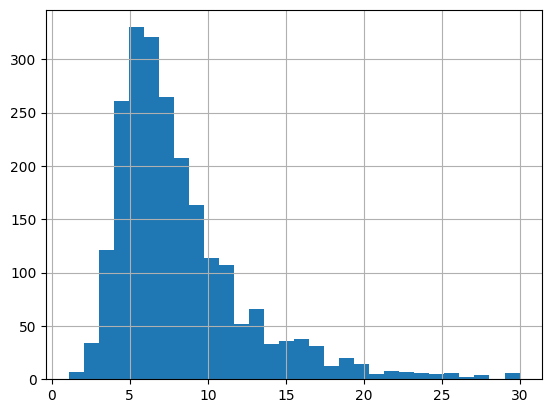

In [322]:
fig = old_segments.speed_mph.hist(bins=30)

<AxesSubplot:>

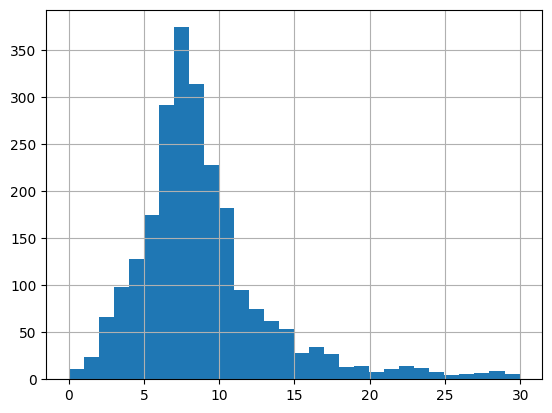

In [327]:
corridor_trips.speed_mph.hist(bins=30)

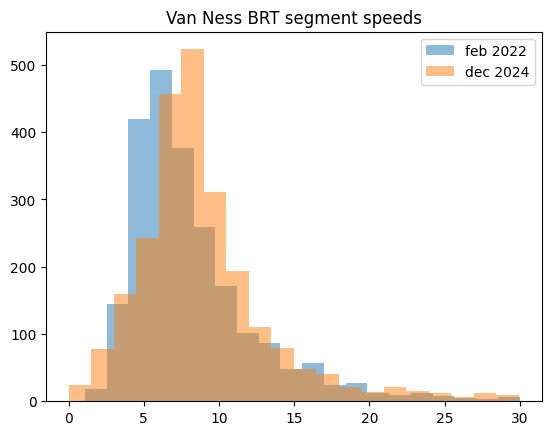

In [331]:
import matplotlib.pyplot as plt

plt.hist(old_segments['speed_mph'],  
         alpha=0.5, # the transaparency parameter 
         label='feb 2022',
         bins=20) 
  
plt.hist(corridor_trips['speed_mph'], 
         alpha=0.5, 
         label='dec 2024',
         bins=20) 
  
plt.legend(loc='upper right') 
plt.title('Van Ness BRT segment speeds') 
plt.show()

In [317]:
len(corridor_trips.trip_instance_key.unique())

310

In [318]:
len(old_segments.trip_key.unique())

182

In [252]:
old_segments.shape

(2322, 25)

In [253]:
corridor_trips.shape

(15387, 27)

In [259]:
corridor_trips.segment_id.unique().shape

(22,)

In [258]:
old_segments.stop_sequence.unique().shape

(29,)